In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from itertools import product

## Process data
Import the CSVs storing each experiment's results, put it together into a DataFrame, and compute some metrics

In [2]:
directory = 'new/noisy_case_combined_optimistic/'
# directory = 'new/noisy_case_combined_fixed/'
outdir = directory

In [72]:
# Compute a 95% CI for the quantity Y/X

def ratio_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y, s_xy = x.std(axis=0), y.std(axis=0), x.cov(y)
    
    c_xx, c_yy = s_x**2 / (mean_x**2 * sample_size), s_y**2 / (mean_y**2 * sample_size)
    c_xy = s_xy / (mean_x * mean_y * sample_size)
    
    mid = 1-(tee**2)*c_xy
    half = tee*np.sqrt(c_xx + c_yy - 2*c_xy - tee**2 * (c_xx*c_yy - c_xy**2))
    scale = mean_y/(mean_x * (1-(tee**2)*c_xx))
    
    lower, upper = scale*(mid - half), scale*(mid+half)
    raw = mean_y/mean_x

    return [1 - raw, upper-raw, raw-lower]

def diff_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y = x.std(axis=0), y.std(axis=0)
    
    mid = mean_x - mean_y
    half = tee*np.sqrt(s_x**2/sample_size + s_y**2/sample_size)
    
    return [mid, half, half]

def diff_paired_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean = x.mean(axis=0) - y.mean(axis=0)
    s = (x-y).std(axis=0)
    
    mid = mean
    half = tee* s / np.sqrt(sample_size)
    
    return [mid, half, half]

Compute the relative cost difference of using the fluid policy w/r/t the equilibrium policy and the simple policy.

In [4]:
all_dfs = []

times = []
param_settings = []
default_params = {
    'lambda' : 9.8,
    'nu' : 1/15,
    'mu' : 1/4,
    'h' : 0.2,
    'r' : 1.0,
    'C' : "lambda p: 10*1.0*(0.2-p)",
    'x_0' : 100,
    'y_0' : 100,
    'fluctuation': 0.5,
    'period': 1
}
with open(directory + "sims.log", "r") as logs:
    for line in logs.readlines():
        start = line.find("{")
        times.append(line[:start - 1])
        params = default_params.copy()
        params.update(eval(line[start:]))
        param_settings.append(params)

paths = sorted([file for file in os.listdir(directory) if file.endswith('.csv')])
for file, params in zip(paths, param_settings):
    df = pd.read_csv(directory + file, index_col=0)
    for param, val in params.items():
        df[param] = val
    all_dfs.append(df)

In [59]:
64000/2000

32.0

In [63]:
df[(df.init == '(60, 60)') & (df.h == 2500)].shape

(64000, 67)

In [68]:
df[(df.init == '(60, 60)') & (df.h == 2500)].iloc[:]

(64000, 67)

In [82]:
for _i in range(1,32):
    tmp = df[(df.init == '(60, 60)') & (df.h == 2500)].iloc[:_i * 2000]
    _a, _b, _c = diff_of_means(tmp['total_cost.1'], tmp['total_cost.2'], len(tmp))
    print(_a/90, (_a-_c)/90, (_a+_c)/90)

-176.6774294131539 -1487.163813141805 1133.808954315497
615.4987805299047 -309.1500062576134 1540.1475673174227
835.4026093181378 77.58651498378798 1593.2187036524876
966.2624234951205 308.88988232799386 1623.634964662247
960.7078991848769 376.0861126318393 1545.3296857379144
943.9126997307305 411.0994373498935 1476.7259621115677
870.1321211594675 377.4146553865823 1362.8495869323526
772.66024756548 311.45850085092985 1233.86199428003
640.6394552104434 206.85725479442092 1074.4216556264657
545.3302277931323 134.37420134076118 956.2862542455033
482.7349040670786 89.83552134161638 875.6342867925407
404.42525470762826 28.385571351213002 780.4649380640434
366.12132523511536 5.233771639026559 727.0088788312041
333.28938568724425 -14.139838497149848 680.7186098716384
320.47328424369914 -15.583583743593893 656.5301522309923
309.95743961376655 -16.4255723884695 636.3404516160026
284.7421170644876 -32.60174417131032 602.0859783002855
215.29060935300464 -92.98083261645488 523.5620513224641
241.5

In [48]:
new_df[(new_df.init == '(60, 60)') & (new_df.h == 2500)].iloc[0]

scale                            50
init                       (60, 60)
rate                       5.907057
h                              2500
period                            1
fluctuation                     0.8
M                              1110
raw_eq                 11522.888827
below_eq                 283.602683
above_eq                 283.602683
raw_simple                 44.95653
below_simple             231.148701
above_simple             231.148701
raw_eq_rel                20.407734
below_eq_rel               0.439538
above_eq_rel               0.436882
raw_simple_rel             0.099936
below_simple_rel            0.51434
above_simple_rel           0.511777
p_eq                       0.140994
p_ci_eq                         0.0
p_simple                   0.101886
p_ci_simple                0.000069
p_opt                      0.109021
p_ci_opt                   0.000074
p_time_eq                  0.737805
p_time_ci_eq               0.001515
p_time_simple              0

In [5]:
df = pd.concat(all_dfs).reset_index(drop=True)

In [6]:
df['init'] = [str(tup) for tup in zip(df['x_0'], df['y_0'])]
df.init.mask(df.x_0 == 43, 'Long-run', inplace=True)
df.drop(columns=['x_0', 'y_0'], inplace=True)

In [7]:
grouped = df.groupby(by=['scale', 'init', 'lambda', 'h', 'period', 'fluctuation', 'M'])#, as_index=False)

In [8]:
stat = 'total_cost'

In [9]:
raw_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[0])
below_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[1])
above_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[2])

raw_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[0])
below_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[1])
above_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat+ '.1'], x[stat + '.2'], len(x))[2])

In [10]:
raw_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

raw_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

In [11]:
p_eq = grouped['mean_p'].mean()
p_ci_eq = 1.96 * grouped['mean_p'].std() / np.sqrt(grouped.size())
p_simple = grouped['mean_p.1'].mean()
p_ci_simple = 1.96 * grouped['mean_p.1'].std() / np.sqrt(grouped.size())
p_opt = grouped['mean_p.2'].mean()
p_ci_opt = 1.96 * grouped['mean_p.2'].std() / np.sqrt(grouped.size())

In [12]:
p_time_eq = grouped['mean_p_time'].mean()
p_time_ci_eq = 1.96 * grouped['mean_p_time'].std() / np.sqrt(grouped.size())
p_time_simple = grouped['mean_p_time.1'].mean()
p_time_ci_simple = 1.96 * grouped['mean_p_time.1'].std() / np.sqrt(grouped.size())
p_time_opt = grouped['mean_p_time.2'].mean()
p_time_ci_opt = 1.96 * grouped['mean_p_time.2'].std() / np.sqrt(grouped.size())

In [13]:
cong_time_eq = grouped['mean_congested_time'].mean()
cong_time_ci_eq = 1.96 * grouped['mean_congested_time'].std() / np.sqrt(grouped.size())
cong_time_simple = grouped['mean_congested_time.1'].mean()
cong_time_ci_simple = 1.96 * grouped['mean_congested_time.1'].std() / np.sqrt(grouped.size())
cong_time_opt = grouped['mean_congested_time.2'].mean()
cong_time_ci_opt = 1.96 * grouped['mean_congested_time.2'].std() / np.sqrt(grouped.size())

In [14]:
new_df = pd.concat([raw_eq, below_eq, above_eq,
                    raw_simple, below_simple, above_simple,
                    raw_eq_rel, below_eq_rel, above_eq_rel,
                    raw_simple_rel, below_simple_rel, above_simple_rel,#],
                    p_eq, p_ci_eq, p_simple, p_ci_simple, p_opt, p_ci_opt,
                    p_time_eq, p_time_ci_eq, p_time_simple, p_time_ci_simple, p_time_opt, p_time_ci_opt,
                    cong_time_eq, cong_time_ci_eq, cong_time_simple, cong_time_ci_simple, cong_time_opt, cong_time_ci_opt,
                   ],
                   axis=1).reset_index()
new_df.columns = ['scale', 'init', 'rate', 'h', 'period', 'fluctuation', 'M',
                  'raw_eq', 'below_eq', 'above_eq', 'raw_simple', 'below_simple', 'above_simple',
                  'raw_eq_rel', 'below_eq_rel', 'above_eq_rel', 'raw_simple_rel', 'below_simple_rel', 'above_simple_rel',#]
                  'p_eq', 'p_ci_eq', 'p_simple', 'p_ci_simple', 'p_opt', 'p_ci_opt',
                  'p_time_eq', 'p_time_ci_eq', 'p_time_simple', 'p_time_ci_simple', 'p_time_opt', 'p_time_ci_opt',
                  'cong_time_eq', 'cong_time_ci_eq', 'cong_time_simple', 'cong_time_ci_simple', 'cong_time_opt', 'cong_time_ci_opt'
                 ]

## Plotting
Isolate the effect of each parameter: hold all others fixed (i.e. group by the other parameters, and then analyze each group separately), and plot against the parameter being varied.

In [15]:
# grays = ['lightgray', 'darkgray', 'dimgray', 'black']
grays = ['green', 'teal', 'blue', 'black']

In [16]:
rates = sorted(new_df.rate.unique())
hs = sorted(new_df.h.unique())
inits = sorted(new_df.init.unique())
Ms = sorted(new_df.M.unique())

fluctuations = sorted(new_df.fluctuation.unique())
periods = sorted(new_df.period.unique())

## Mean intervention

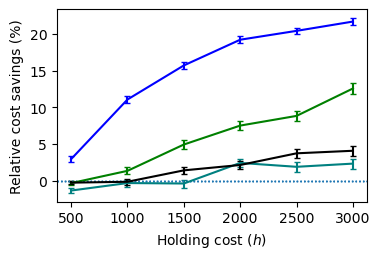

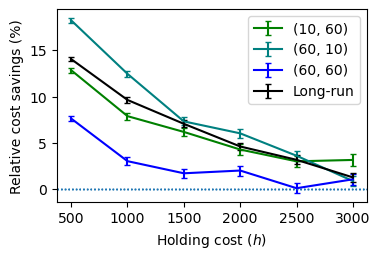

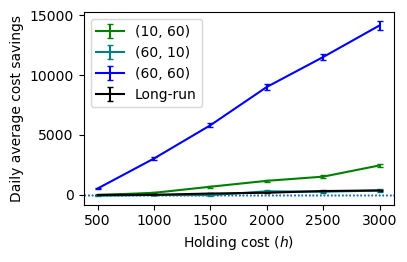

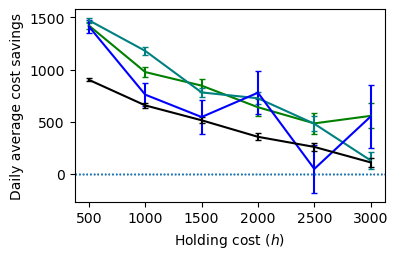

In [83]:
# Plot separately, for export

xlabel = r"Holding cost ($h$)"
xvar = "h"

ylabels = {
    'eq_rel' : "Relative cost savings (%)",
    'simple_rel' : "Relative cost savings (%)",
    'eq' : "Daily average cost savings",
    'simple' : "Daily average cost savings"
}
ylims = {
    var_name : [(new_df['raw_{}'.format(var_name)] - 2*new_df['below_{}'.format(var_name)]).min(),
              (new_df['raw_{}'.format(var_name)] + 2*new_df['above_{}'.format(var_name)]).max()] \
    for var_name in ylabels
}

ylims['eq_rel'][0] = ylims['simple_rel'][0] = min(ylims['eq_rel'][0], ylims['simple_rel'][0])
ylims['eq_rel'][1] = ylims['simple_rel'][1] = max(ylims['eq_rel'][1], ylims['simple_rel'][1])

ylims['eq'][0] = ylims['simple'][0] = min(ylims['eq'][0], ylims['simple'][0])
ylims['eq'][1] = ylims['simple'][1] = max(ylims['eq'][1], ylims['simple'][1])

def save_errorbars(data, var_name, fig_name, legend=False):
    
    fig, ax = plt.subplots()
    for j, init in enumerate(inits):
        subset = data[data.init == init].sort_values(by=xvar)
        ax.errorbar(subset[xvar], subset['raw_{}'.format(var_name)],
                    yerr=[subset['below_{}'.format(var_name)], subset['above_{}'.format(var_name)]],
                   capsize=2,
                   color=grays[j],
                   label=init)
        # plt.ylim(ylims[var_name])
        ax.axhline(0, linewidth=1, linestyle='dotted')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabels[var_name])
        
        if legend:
            ax.legend()
            
        fig.set_figheight(2.5)
        fig.set_figwidth(4)
            
        plt.savefig(outdir + 'case_{}_{}.pdf'.format(var_name, fig_name), bbox_inches='tight')

for i, val in enumerate(Ms):
    fig_name = 'cost_{}'.format(val)
    bigset = new_df[new_df.M == val]
    save_errorbars(bigset, 'eq_rel', fig_name, False)
    save_errorbars(bigset, 'simple_rel', fig_name, True)
    save_errorbars(bigset, 'eq', fig_name, True)
    save_errorbars(bigset, 'simple', fig_name)

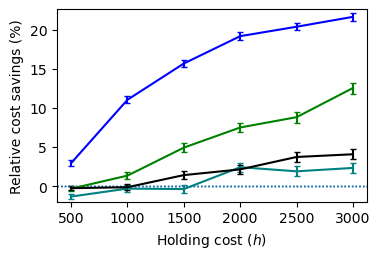

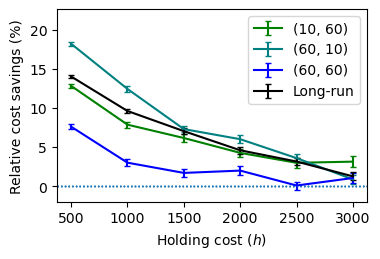

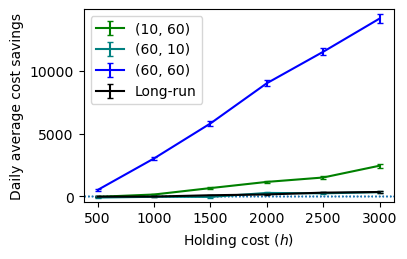

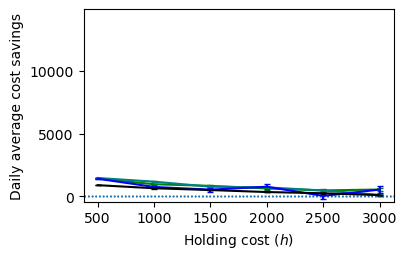

In [23]:
# # Plot separately, for export

# xlabel = r"Holding cost ($h$)"
# xvar = "h"

# ylabels = {
#     'eq_rel' : "Relative cost savings (%)",
#     'simple_rel' : "Relative cost savings (%)",
#     'eq' : "Daily average cost savings",
#     'simple' : "Daily average cost savings"
# }
# ylims = {
#     var_name : [(new_df['raw_{}'.format(var_name)] - 2*new_df['below_{}'.format(var_name)]).min(),
#               (new_df['raw_{}'.format(var_name)] + 2*new_df['above_{}'.format(var_name)]).max()] \
#     for var_name in ylabels
# }

# ylims['eq_rel'][0] = ylims['simple_rel'][0] = min(ylims['eq_rel'][0], ylims['simple_rel'][0])
# ylims['eq_rel'][1] = ylims['simple_rel'][1] = max(ylims['eq_rel'][1], ylims['simple_rel'][1])

# ylims['eq'][0] = ylims['simple'][0] = min(ylims['eq'][0], ylims['simple'][0])
# ylims['eq'][1] = ylims['simple'][1] = max(ylims['eq'][1], ylims['simple'][1])

# def save_errorbars(data, var_name, fig_name, legend=False):
    
#     fig, ax = plt.subplots()
#     for j, init in enumerate(inits):
#         subset = data[data.init == init].sort_values(by=xvar)
#         ax.errorbar(subset[xvar], subset['raw_{}'.format(var_name)],
#                     yerr=[subset['below_{}'.format(var_name)], subset['above_{}'.format(var_name)]],
#                    capsize=2,
#                    color=grays[j],
#                    label=init)
#         plt.ylim(ylims[var_name])
#         ax.axhline(0, linewidth=1, linestyle='dotted')
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel(ylabels[var_name])
        
#         if legend:
#             ax.legend()
            
#         fig.set_figheight(2.5)
#         fig.set_figwidth(4)
            
#         plt.savefig(outdir + 'case_{}_{}.pdf'.format(var_name, fig_name), bbox_inches='tight')

# for i, val in enumerate(Ms):
#     fig_name = 'cost_{}'.format(val)
#     bigset = new_df[new_df.M == val]
#     save_errorbars(bigset, 'eq_rel', fig_name, False)
#     save_errorbars(bigset, 'simple_rel', fig_name, True)
#     save_errorbars(bigset, 'eq', fig_name, True)
#     save_errorbars(bigset, 'simple', fig_name)